PROBLEM DESCRIPTION 

The main part of this proyect is explain the fluctuations in the duration of the trips of the yellow taxis of the NY city during the first 3 months of 2022. 

New York is one of the biggest cities around the world, therefore, known about the duration of the trips is an excellent way to analyze the vehicle movements in the city and what are the variables that explains better that results. 

For this model, was developed a Linear Regression model that has 5 categorical variables that are the locations, price, passengers_count and trip distance. 



In [1]:
## Libraries
import pandas as pd
import numpy as np
import sklearn as sk
import datetime as dt
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
import argparse
import os
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import argparse
import mlflow
from hyperopt import hp, space_eval
from hyperopt.pyll import scope
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [2]:
## Import dataset 1
df = pd.read_parquet("/Users/agvg/Documents/DS/MLOPS/MLOPS/Final_Project/yellow_tripdata_2022-01.parquet")
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN


In [7]:
#Import second data set 

df2 = pd.read_parquet("/Users/agvg/Documents/DS/MLOPS/MLOPS/Final_Project/yellow_tripdata_2022-02.parquet")

In [15]:
#Create target variables
df ["duration"] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime) / pd.Timedelta('1 minute')
df2 ["duration"] = (df2.tpep_dropoff_datetime - df2.tpep_pickup_datetime) / pd.Timedelta('1 minute')

In [16]:
## Take out columns with a duration of 1 hour or more
df = df[df['duration'] <= 60]
df2 = df2[df2['duration'] <= 60]

In [17]:
## Take out nulls 
df = df.dropna()
df2 = df2.dropna()

In [11]:
## Select categorical variables
categorical = ['PULocationID', 'DOLocationID','trip_distance','fare_amount','passenger_count','tpep_pickup_datetime','tpep_dropoff_datetime']
df[categorical].dtypes
df[categorical] = df[categorical].astype(str)

## CLEAN January data set
##train model
train = df[categorical].to_dict(orient='records')

## Vectorize the train DF
DV = DictVectorizer()
X_train = DV.fit_transform(train)

## Stablish the dependent variable as y variable
target = 'duration'
y_train = df[target].values

In [12]:
## Linear regression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
rmse = mean_squared_error(y_train, y_pred, squared=False)

/opt/anaconda3/envs/MLOPS/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/MLOPS/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


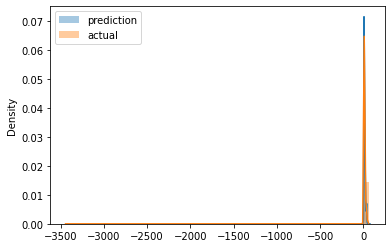

In [21]:
#Plot the model with the first data
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [13]:
## train model 

test_dicts = df2[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_test = dv.fit_transform(test_dicts)

target = 'duration'
y_test = df2[target].values

lr = LinearRegression()
lr.fit(X_test, y_test)
y_pred_test = lr.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print(test_rmse)

5.661031973225414


/opt/anaconda3/envs/MLOPS/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/MLOPS/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


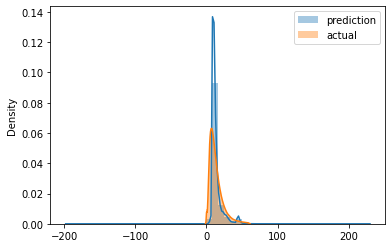

In [28]:
## Plot validation model
sns.distplot(y_pred_test, label='prediction')
sns.distplot(y_test, label='actual')

plt.legend()

In [29]:
## Save model
with open('/Users/agvg/Documents/DS/MLOPS/MLOPS/Final_Project/lin_reg.bin','wb') as f_out:
 pickle.dump((dv,lr), f_out)